# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

#### Use this framework to incorporate Card Count?

In [1]:
# For some reason, importing this first doesn't crash the kernel

import torch
import torch.nn as nn

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Import learned Q function to be used for comparison

In [4]:
Qlearned = np.load('Q.npy',allow_pickle=True).item()

In [5]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

card_comb_all = []
card_comb = [[c1,c2] for i,c1 in enumerate(allCards) for c2 in allCards[i:]]
all_comb = [[c1,c2] for c1 in allCards for c2 in allCards]
for c in card_comb :
    for a in all_comb :
        card_comb_all.append([[c]]+[a])

### Observe distribution of Card Count in several games played.

The module automatically handles reshuffling, so I can just repeat play without re-initializing the module.

I have a "ratio penetrate" flag, which defaults to 4/6 . This means that the deck is reshuffled after it gets through 4/6'ths of the deck. I default to 6 deck game as well. You can adjust these values in the Game module.

The distribution of count will be dependent on number of decks used, and ratio penetrate. Although with large ratio penetrate, the distribution might seem a bit misleading. This is because, if there is a large/small count at the point of reshuffling, we neglect the fact that if we play every card (instead of stopping short to reshuffle), the count will converge back to 0 by the end of the deck.

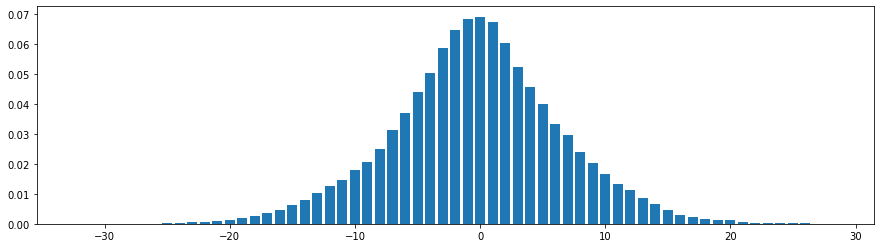

In [9]:
blackjack = Game(Player,verbose=False)
count = []

for _ in range(50000) :
    
    count.append(blackjack.count)
    
    blackjack.initRound(wagers=[1])
    blackjack.dealInit()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    houseShow = blackjack.getHouseShow(showValue=True)

    while not player.isDone() :

        playerShow,canSplit,useableAce,card1 = player.getValue()

        policy = player.getValidMoves(houseShow)
        policy = [p for p in policy if p!='insurance']
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,False)
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,False)

        count.append(blackjack.count)

        blackjack.stepPlayer(player,move)
    blackjack.stepHouse()
    
plt.figure(figsize=(15,4))
inds = np.argsort(pd.Series(count).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(count).value_counts(normalize=True).index[inds],
    pd.Series(count).value_counts(normalize=True).values[inds]
)
plt.show()

## Deep Q Learning


The Q learning without card count is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

In Deep Q Learning, we are ultimately approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE between predicted and actual Q values. We will ultimately be regressing the Q value for each possible action for a given state.

In [10]:
class Net(nn.Module) :
    
    def __init__(self, input_dim, output_dim, hidden_layers=[]) :
        super(Net, self).__init__()
        
        assert len(hidden_layers) , "must have at least 1 hidden layer"
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.fc_input = nn.Linear(self.input_dim, self.hidden_layers[0])
        self.relu = nn.ReLU()
        
        self.fc_hidden = []
        for i in range(len(self.hidden_layers)-1) :
            self.fc_hidden.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
            
        self.fc_output = nn.Linear(self.hidden_layers[-1], self.output_dim)
        
    def forward(self, data) :
        
        x = self.relu(self.fc_input(data))
        
        for layer in self.fc_hidden :
            x = self.relu(layer(x))
        
        return self.fc_output(x)
            


In [7]:
class Net(nn.Module) :
    
    def __init__(self, input_dim, output_dim, hidden1, hidden2) :
        super(Net, self).__init__()
                
        self.input_dim = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.output_dim = output_dim
        self.relu = nn.ReLU()
        self.fc_input = nn.Linear(self.input_dim, self.hidden1)
        self.fc_hidden = nn.Linear(self.hidden1, self.hidden2)
        self.fc_output = nn.Linear(self.hidden2, self.output_dim)
        
    def forward(self, data) :
        
        x = self.relu(self.fc_input(data))
        x = self.relu(self.fc_hidden(x))
        
        
        return self.fc_output(x)

In [12]:
net = Net(2,5,[10,12])

In [13]:
net.forward(torch.Tensor([1,2]))

tensor([ 0.1933,  0.0222, -0.3071,  0.3606, -0.2790], grad_fn=<AddBackward0>)

In [61]:
net.zero_grad()